# **Ekstraksi Kata Kunci Berita Online**
Dalam hal ini mencari dimana kata - kata kunci atau kata - kata paling penting dalam suatu kalimat pada dokument berita yang telah dicrawling sebelumnya pada website kompas.com

In [ ]:
# sambung ke google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Library

In [ ]:
!pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00


In [ ]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import nltk
import re
import joblib
import string

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# load data
data = pd.read_csv('/content/drive/MyDrive/ppw/ppw_implementasi/tugas ppw/dataset/berita_kompas.csv')
data

,Judul_Artikel,Tanggal Publish,Content_Artikel,Category
0,Jadwal Timnas Indonesia Malam Ini di Piala Dun...,"13/11/2023, 14:14 WIB",KOMPAS.com - Jadwal timnas Indonesia malam ini...,Sports
1,Eks Pelatih Garuda soal 2 Pemain Keturunan di ...,"13/11/2023, 13:20 WIB",KOMPAS.com - Keberadaan dua pemain keturunan d...,Sports
2,Cerita Jurnalis Mali di Piala Dunia U17: Dari ...,"13/11/2023, 12:15 WIB",KOMPAS.com - Dua jurnalis Mali hadir langsung ...,Sports
3,"Piala Dunia U17 2023, Jurnalis Ekuador Bicara ...","13/11/2023, 11:30 WIB","Laporan langsung jurnalis Kompas.com, Ahmad Zi...",Sports
4,5 MVP Turnamen Bold Battle of Legends 2023 Jal...,"13/11/2023, 11:03 WIB",KOMPAS.com - Rangkaian turnamen esports Bold B...,Sports
...,...,...,...,...
805,Penunggak Pajak Kendaraan Diumumkan di SPBU Be...,"08/11/2023, 06:22 WIB","JAKARTA, KOMPAS.com - Corporate Secretary Pert...",Otomotif
806,[POPULER OTOMOTIF] Intip Bodi Bus Langka Milik...,"08/11/2023, 06:02 WIB","JAKARTA, KOMPAS.com - Seiring perubahan zaman ...",Otomotif
807,"Subaru DriveFest di Batam, Tutup Perayaan 50 T...","07/11/2023, 20:21 WIB","JAKARTA, KOMPAS.com - Subaru Indonesia menggel...",Otomotif
808,"Ada Balap Resmi, Bamsoet Minta Pengguna Moge T...","07/11/2023, 20:11 WIB","JAKARTA, KOMPAS.com - Salah satu grup terbesar...",Otomotif


In [ ]:
# Hitung jumlah kelas
kelas = data['Category'].value_counts()
kelas

Sports      270
Edukasi     270
Otomotif    270
Name: Category, dtype: int64

In [ ]:
data.isnull().sum()

Judul_Artikel      0
Tanggal Publish    0
Content_Artikel    0
Category           0
dtype: int64

In [ ]:
data.duplicated().sum()

0

## Clean data
Proses cleaning data digunakan untuk menghapus karakter tertentu dimana fungsi cleaning digunakan untuk membersihkan teks dalam kolom ‘Content_Artikel’. Ini menghapus karakter-karakter yang tidak relevan seperti tanda baca dan mengubah teks menjadi daftar kata-kata.

In [ ]:
# membuat kolom baru dengan nama new_abstrak untuk data baru yang dipunctuation
data['clean_content'] = data['Content_Artikel'].str.replace('[{}]'.format(string.punctuation), '').str.lower()

# Menghilangkan angka dari kolom 'new_abstrak'
data['clean_content'] = data['clean_content'].str.replace('\d+', '', regex=True)
data['clean_content']

0      kompascom  jadwal timnas indonesia malam ini p...
1      kompascom  keberadaan dua pemain keturunan di ...
2      kompascom  dua jurnalis mali hadir langsung ke...
3      laporan langsung jurnalis kompascom ahmad zilk...
4      kompascom  rangkaian turnamen esports bold bat...
                             ...                        
805    jakarta kompascom  corporate secretary pertami...
806    jakarta kompascom  seiring perubahan zaman dan...
807    jakarta kompascom  subaru indonesia menggelar ...
808    jakarta kompascom  salah satu grup terbesar pe...
809    bogor kompascom  mazda mx sudah tidak dilanjut...
Name: clean_content, Length: 810, dtype: object

## Tokenizing
Fungsi tokenizer digunakan untuk melakukan tokenisasi dan juga proses case folding pada teks yang telah dibersihkan. Ini mengubah teks menjadi token-token kata.

In [ ]:
def tokenizer(text):
  text = text.lower()
  return sent_tokenize(text)

data["tokenizing"] = data['clean_content'].apply(tokenizer)
data["tokenizing"]

0      [kompascom  jadwal timnas indonesia malam ini ...
1      [kompascom  keberadaan dua pemain keturunan di...
2      [kompascom  dua jurnalis mali hadir langsung k...
3      [laporan langsung jurnalis kompascom ahmad zil...
4      [kompascom  rangkaian turnamen esports bold ba...
                             ...                        
805    [jakarta kompascom  corporate secretary pertam...
806    [jakarta kompascom  seiring perubahan zaman da...
807    [jakarta kompascom  subaru indonesia menggelar...
808    [jakarta kompascom  salah satu grup terbesar p...
809    [bogor kompascom  mazda mx sudah tidak dilanju...
Name: tokenizing, Length: 810, dtype: object

## Ekstraksi Kata Kunci
Memulai ekstraksi kata kunci pada berita 1 yang telah dilakukan tokenizing

In [ ]:
# Mengambil berita ke 1
corpus = data["tokenizing"][0]
corpus

['kompascom  jadwal timnas indonesia malam ini pada lanjutan babak penysiihan grup piala dunia u  bakal menyajikan laga melawan panama hasil bagus akan membuat garuda muda menjaga kans lolos ke babak berikutnya timnas u indonesia akan melanjutkan kiprah pada piala dunia u  dengan menghadapi panama pada matchday kedua grup a laga indonesia vs panama tersebut bakal digelar di stadion gelora bung tomo surabaya pada senin  pukul  wib baca juga indonesia tahan ekuador di piala dunia u laga berat hasil kerja keras\xa0 pada laga perdana kontra ekuador timnas u indonesia besutan bima sakti bermain imbang  garuda muda sebenarnya bisa unggul lebih dulu pada menit ke lewat gol arkhan kaka namun ekuador bisa membalas pada menit ke melalui gol allen obando sementara itu panama kalah  dari maroko pada pertandingan pertama grup a dua gol maroko yang bersarang ke gawang panama dicetak oleh saifdine chlaghmo  dan ayman ennair  baca juga timnas u indonesia vs panama welber jardim ungkap pesan bima sakti

In [ ]:
# Fungsi matriks co-occurence
from nltk.tokenize import word_tokenize
def build_co_occurrence_matrix(corpus,window_size):
    #build unique words
    unique_words=set()
    for text in corpus:
        for word in word_tokenize(text):
            unique_words.add(word)

    word_search_dict={word:np.zeros(shape=(len(unique_words))) for word in unique_words}
    word_list=list(word_search_dict.keys())
    for text in corpus:
        text_list=word_tokenize(text)
        for idx,word in enumerate(text_list):
            #pick word in the size range
            i=max(0,idx-window_size)
            j=min(len(text_list)-1,idx+window_size)
            search=[text_list[idx_] for idx_ in range(i,j+1)]
            search.remove(word)
            for neighbor in search:
                # get neighbor idx in word_search_dict
                nei_idx=word_list.index(neighbor)
                word_search_dict[word][nei_idx]+=1
    return word_search_dict

In [ ]:
# Pemanggilan fungsi dengan data berita 1
coo_dict=build_co_occurrence_matrix(corpus,window_size=1)
coo_dict

{'yang': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'dari': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.

In [ ]:
# Ubah hasil ke dalam datafram
co_occurrence_matrix = pd.DataFrame(coo_dict,index=coo_dict.keys()).astype('int')
co_occurrence_matrix

,yang,dari,unggul,indonesia,allen,di,pukul,u,sakti,surabaya,...,gol,kontra,menjaga,satu,pada,wib,imbang,bung,kerja,obando
yang,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dari,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
unggul,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
indonesia,1,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
allen,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wib,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
imbang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bung,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kerja,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Menampilkan jumlah kemunculan kata
a = co_occurrence_matrix.stack()
a = a[a >= 1].rename_axis(('source', 'target')).reset_index(name='weight')
print(a)

     source      target  weight
0      yang   indonesia       1
1      yang  mengoleksi       1
2      yang   bersarang       1
3      yang      maroko       1
4      dari       kalah       1
..      ...         ...     ...
317    bung        tomo       1
318   kerja       keras       1
319   kerja       hasil       1
320  obando       allen       1
321  obando   sementara       1

[322 rows x 3 columns]


In [ ]:
# Menghitung matriks co-occurrence dengan CountVectorizer
vectorizer = CountVectorizer()
co_occurrence_matrix = vectorizer.fit_transform(corpus).T * vectorizer.fit_transform(corpus)

# Membuat DataFrame dari matriks co-occurrence
df_co_occurrence = pd.DataFrame(co_occurrence_matrix.toarray(), columns=vectorizer.get_feature_names_out(),index=vectorizer.get_feature_names_out())

## Graph Co-occurence Matrics
Membuat bentuk graph dari data matrics co-occurence yang telah dilakukan

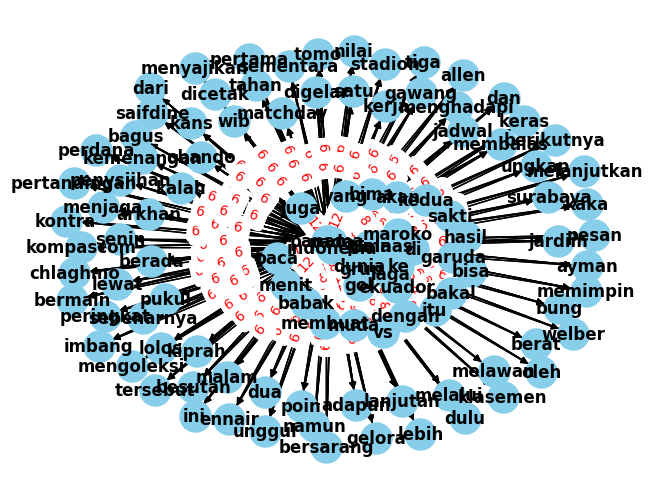

In [ ]:
G = nx.DiGraph()  # Menggunakan Directed Graph agar panah dapat ditampilkan

# Membuat graf dengan edge untuk nilai yang memenuhi kondisi
for idx, row in df_co_occurrence.iterrows():
    for col in df_co_occurrence.columns:
        weight = df_co_occurrence.loc[idx, col]
        if weight > 5 and idx != col:
            G.add_edge(idx, col, weight=weight)

pos = nx.spring_layout(G)  # Penataan node

# Menggambar grafik dengan label edge dan panah
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_color='red')

plt.show()

## Menghitung PageRank Centrality

In [ ]:
# Hitung centrality pada berita 1 dengan PageRank
centrality = nx.pagerank(G)
# Ubah ke dalam dataframe
pagerank_df = pd.DataFrame(list(centrality.items()), columns=['Kata', 'Pagerank Centrality'])
pagerank_df = pagerank_df.sort_values(by='Pagerank Centrality', ascending=False)
pagerank_df

,Kata,Pagerank Centrality
2,pada,0.128370
1,indonesia,0.113079
3,panama,0.097621
9,grup,0.026939
14,timnas,0.026939
...,...,...
56,jardim,0.003135
55,jadwal,0.003135
53,imbang,0.003135
52,gelora,0.003135


## Menghitung Closeness Centrality

In [ ]:
# Hitung centrality pada berita 1 dengan closeness
closeness_centrality = nx.closeness_centrality(G)
# Ubah ke dalam dataframe
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['Kata', 'Closeness Centrality'])
closeness_df = closeness_df.sort_values(by='Closeness Centrality', ascending=False)
closeness_df

,Kata,Closeness Centrality
1,indonesia,1.000000
2,pada,1.000000
3,panama,1.000000
9,grup,0.580645
14,timnas,0.580645
...,...,...
56,jardim,0.507042
55,jadwal,0.507042
53,imbang,0.507042
52,gelora,0.507042


### Peringkat kata berdasarkan nilai centrality tertinggi

In [ ]:
# Mengurutkan peringkat kata-kata berdasarkan centrality
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# Buat dataframe dari hasil peringkat
df = pd.DataFrame(sorted_centrality, columns=['Kata', 'Centrality'])

# Tambahkan kolom peringkat
df['Peringkat'] = df['Centrality'].rank(ascending=False).astype(int)

df

,Kata,Centrality,Peringkat
0,pada,0.128370,1
1,indonesia,0.113079,2
2,panama,0.097621,3
3,dunia,0.026939,6
4,grup,0.026939,6
...,...,...,...
104,tomo,0.003135,70
105,unggul,0.003135,70
106,ungkap,0.003135,70
107,welber,0.003135,70


### Menampilkan Top 5 kata tertinggi

In [ ]:
# Mengambil lima kata teratas
top_5_words = sorted_centrality[:5]

# Membuat DataFrame dari lima kata teratas
top_5_df = pd.DataFrame(top_5_words, columns=['Kata', 'Centrality'])
top_5_df

,Kata,Centrality
0,pada,0.128370
1,indonesia,0.113079
2,panama,0.097621
3,dunia,0.026939
4,grup,0.026939
